Feature  Perc   DropF100   DropL100   Transform  Scaler          Models   Unseen Model                   TrAcc     TrF1   CV_Acc  CV_Prec   CV_Rec    CV_F1 Unseen_Acc Unseen_F1 BestParams          
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4        70%    True       False      none       StandardScaler  6        1      Decision Tree           0.951    0.951    0.453    0.472    0.453    0.445    0.800    0.733 {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
4        70%    True       False      none       StandardScaler  8        1      Decision Tree           0.977    0.977    0.433    0.450    0.433    0.434    0.800    0.733 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
4        70%    True       False      none       StandardScaler  10       1   

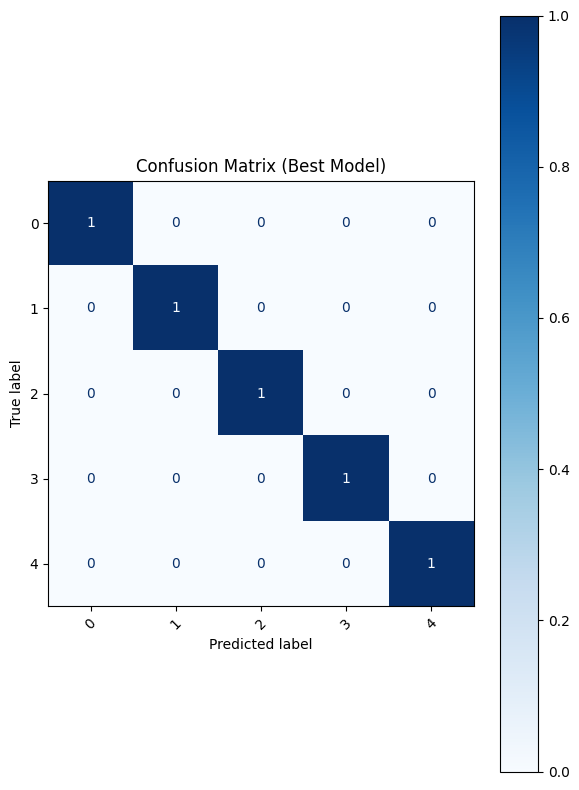

In [2]:
import pandas as pd
import numpy as np
from itertools import product
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.base import clone
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load dataset
url = 'https://raw.githubusercontent.com/AjStephan/olivier-piw/main/dataplasmonic.csv'
df = pd.read_csv(url)

# Separate features and targets
X = pd.concat([df.iloc[:, :-4], df.iloc[:, -2]], axis=1)
y_targets = df.iloc[:, -4:]

# Parameter grid
percentage_options = [0.7, 0.8, 0.9]
drop_first_100_options = [True]
drop_last_100_options = [False]
transform_options = [2]
scaler_options = [
    StandardScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler(),
    Normalizer()
]
n_models_options = [6, 8, 10]
numb_unseen = [1]
featurec_col = [4]

# Classifiers and hyperparameters
classifiers = {
    "Decision Tree": (
        DecisionTreeClassifier(),
        {'max_depth': [None, 5, 10], 'criterion': ['gini', 'entropy'],
         'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
    )
}

def select_closest_to_mean(df, percentage):
    selected_indices = []
    min_samples = min(df['label'].value_counts())
    n_samples = int(round(min_samples * percentage))
    for label in df['label'].unique():
        class_data = df[df['label'] == label].drop(columns=['label'])
        actual_n_samples = min(n_samples, len(class_data))
        class_mean = class_data.mean().values.reshape(1, -1)
        distances = cdist(class_data.values, class_mean).flatten()
        closest_indices = class_data.index[np.argsort(distances)[:actual_n_samples]]
        selected_indices.extend(closest_indices)
    return df.loc[selected_indices]

# Header for results
header = (
    "{:<8} {:<6} {:<10} {:<10} {:<10} {:<15} {:<8} {:<6} {:<20} "
    "{:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:<20}"
).format(
    "Feature", "Perc", "DropF100", "DropL100", "Transform", "Scaler", "Models", "Unseen", "Model",
    "TrAcc", "TrF1", "CV_Acc", "CV_Prec", "CV_Rec", "CV_F1", "Unseen_Acc", "Unseen_F1", "BestParams"
)
print(header)
print("-" * len(header))

all_results = []

for (feature, percentage, drop_first_100, drop_last_100, transform, scaler, n_models, unseen) in product(
    featurec_col, percentage_options, drop_first_100_options, drop_last_100_options,
    transform_options, scaler_options, n_models_options, numb_unseen
):
    try:
        y = y_targets.iloc[:, -feature]
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        X_transformed = -np.log(X / 100) if transform == 1 else X
        transform_name = "log" if transform == 1 else "none"

        X_scaled = scaler.fit_transform(X_transformed)
        df_combined = pd.DataFrame(X_scaled)
        df_combined['label'] = y_encoded

        df_selected = select_closest_to_mean(df_combined, percentage)

        np.random.seed(42)

        unseen_indices = []
        unseen_labels = []

        for label in df_combined['label'].unique():
            label_indices = df_combined[df_combined['label'] == label].index
            chosen_index = np.random.choice(label_indices, size=1, replace=False)[0]
            unseen_indices.append(chosen_index)
            unseen_labels.append(label)

        X_train = df_combined.drop(index=unseen_indices).drop(columns='label').values
        y_train = df_combined.drop(index=unseen_indices)['label'].values

        for name, (clf, params) in classifiers.items():
            grid = GridSearchCV(clf, params, cv=4, scoring='f1_weighted', n_jobs=-1)
            grid.fit(X_train, y_train)

            train_preds = grid.best_estimator_.predict(X_train)
            train_acc = accuracy_score(y_train, train_preds)
            train_f1 = f1_score(y_train, train_preds, average='weighted')

            cv_results = cross_validate(grid.best_estimator_, X_train, y_train,
                                        cv=4, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], n_jobs=-1)

            X_unseen = df_combined.loc[unseen_indices].drop(columns='label').values
            y_unseen = df_combined.loc[unseen_indices]['label'].values

            predictions = []
            for _ in range(n_models):
                X_sample, y_sample = resample(X_train, y_train, n_samples=int(0.8 * len(X_train)))
                model = clone(grid.best_estimator_)
                model.fit(X_sample, y_sample)
                predictions.append(model.predict(X_unseen))

            predictions = np.array(predictions).T
            final_preds = [Counter(p).most_common(1)[0][0] for p in predictions]

            unseen_acc = accuracy_score(y_unseen, final_preds)
            unseen_f1 = f1_score(y_unseen, final_preds, average='weighted')
            best_params_str = str(grid.best_params_)

            print("{:<8} {:<6.0%} {:<10} {:<10} {:<10} {:<15} {:<8} {:<6} {:<20} "
                  "{:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:<20}".format(
                feature, percentage, str(drop_first_100), str(drop_last_100), transform_name,
                scaler.__class__.__name__, n_models, unseen, name,
                train_acc, train_f1,
                np.mean(cv_results['test_accuracy']),
                np.mean(cv_results['test_precision_weighted']),
                np.mean(cv_results['test_recall_weighted']),
                np.mean(cv_results['test_f1_weighted']),
                unseen_acc, unseen_f1, best_params_str
            ))

            all_results.append({
                'Feature': feature,
                'Percentage': percentage,
                'Drop_First_100': drop_first_100,
                'Drop_Last_100': drop_last_100,
                'Transform': transform_name,
                'Scaler': scaler.__class__.__name__,
                'Num_Models': n_models,
                'Unseen': unseen,
                'Model': name,
                'Train_Accuracy': train_acc,
                'Train_F1': train_f1,
                'CV_Accuracy': np.mean(cv_results['test_accuracy']),
                'CV_Precision': np.mean(cv_results['test_precision_weighted']),
                'CV_Recall': np.mean(cv_results['test_recall_weighted']),
                'CV_F1': np.mean(cv_results['test_f1_weighted']),
                'Unseen_Accuracy': unseen_acc,
                'Unseen_F1': unseen_f1,
                'Best_Params': best_params_str,
                'Unseen_Labels': y_unseen,
                'Unseen_Indices': unseen_indices,
                'Preds_Unseen': final_preds,
                'Best_Model': grid.best_estimator_,
                'Label_Encoder': label_encoder
            })

    except Exception as e:
        print(f"Error with parameters ({feature}, {percentage}, {drop_first_100}, {drop_last_100}, ...): {e}")

# Save results
results_df = pd.DataFrame(all_results)
results_df.to_csv("model_results_DT_none_new.csv", index=False)
print("\nAll results saved to model_results_DT_none_new.csv")

# Select best model
best_entry = max(all_results, key=lambda x: (x['Unseen_Accuracy'], x['CV_Accuracy']))

print("\nBest Model Info:")
print(f"Model: {best_entry['Model']}")
print(f"Scaler: {best_entry['Scaler']}")
print(f"Parameters: {best_entry['Best_Params']}")
print(f"Unseen Accuracy: {best_entry['Unseen_Accuracy']:.3f}")
print(f"Unseen F1 Score: {best_entry['Unseen_F1']:.3f}")

# Decode predictions
encoder = best_entry['Label_Encoder']
true_labels = best_entry['Unseen_Labels']
pred_labels = best_entry['Preds_Unseen']

# Confusion Matrix
cm = confusion_matrix(best_entry['Unseen_Labels'], best_entry['Preds_Unseen'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 8))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix (Best Model)")
plt.tight_layout()
plt.show()

In [ ]:
# Classification Report
report = classification_report(true_labels, pred_labels, target_names=encoder.classes_)
print("\nClassification Report:\n")
print(report)

# Performance Bar Plot
plt.figure(figsize=(8, 4))
metrics = ['Train_Accuracy', 'CV_Accuracy', 'Unseen_Accuracy', 'Train_F1', 'CV_F1', 'Unseen_F1']
values = [best_entry[m] for m in metrics]
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0.0, 1.05)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()